# Application

Dans cette séance, nous verrons l'application des 2 méthodes (ACP et classification) pour rechercher les différentes façons d'écrire chaque chiffre.

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt

%matplotlib inline

Nous allons utiliser les données [`pendigits`](https://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits) de l'*UCI Machine Learning Repository*. Ces données représentent le tracé des chiffres de 0 à 9 par plusieurs personnes. Pour chaque tracé, nous n'avons au final que les coordonnées $(X,Y)$ de 8 points et le chiffre tracé.

Voici ci dessous comment importer les données directement.

In [2]:
pen_tes = pandas.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tes", 
                          header=None)
pen_tra = pandas.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra", 
                          header=None)
pen = pen_tes.copy().append(pen_tra, ignore_index = True)
print(pen.shape)
pen.head()

(10992, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,88,92,2,99,16,66,94,37,70,0,0,24,42,65,100,100,8
1,80,100,18,98,60,66,100,29,42,0,0,23,42,61,56,98,8
2,0,94,9,57,20,19,7,0,20,36,70,68,100,100,18,92,8
3,95,82,71,100,27,77,77,73,100,80,93,42,56,13,0,0,9
4,68,100,6,88,47,75,87,82,85,56,100,29,75,6,0,0,9


Comme vous le pouvez le remarquer, les noms des variables ne sont pas renseignés. Celles-ci sont $(x_j, y_j)_{j = 1,\ldots,8}$ et le chiffre. On va donc déjà créer le vecteur correspondant.

In [3]:
a = [c + n for c, n in zip(["x", "y"] * 8, [str(x) for x in range(1, 9) for i in range(2)])]
a.append("chiffre")
print(a)

['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'chiffre']


On va ensuite renommer les colonnes avec ce vecteur.

In [4]:
pen.columns = a
pen.head()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,chiffre
0,88,92,2,99,16,66,94,37,70,0,0,24,42,65,100,100,8
1,80,100,18,98,60,66,100,29,42,0,0,23,42,61,56,98,8
2,0,94,9,57,20,19,7,0,20,36,70,68,100,100,18,92,8
3,95,82,71,100,27,77,77,73,100,80,93,42,56,13,0,0,9
4,68,100,6,88,47,75,87,82,85,56,100,29,75,6,0,0,9


Par la suite, nous aurons besoin d'accéder aux $x_j$ uniquement, ou aux $y_j$, voire aux deux. Nous créons donc des vecteurs avec les noms de variables. 

In [5]:
xN = ["x" + str(i + 1) for i in range(8)]
print(xN)
yN = ["y" + str(i + 1) for i in range(8)]
print(yN)
xyN = [a + b for a,b in zip(["x", "y"] * 8, [str(i + 1) for i in range(8) for j in range(2)])]
print(xyN)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8']
['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8']


Ces données ont l'avantage d'être graphique. Nous allons donc représenter le premier tracé, qui est un $8$.

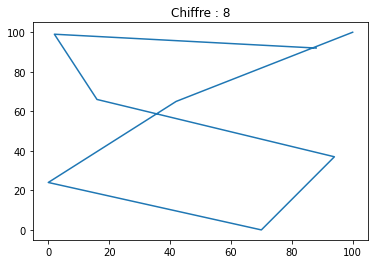

In [6]:
x = pen.loc[0, xN]
y = pen.loc[0, yN]
chiffre = pen.loc[0, "chiffre"]
plt.plot(x, y)
plt.title("Chiffre : " + str(chiffre))
plt.show()

Nous allons régulièrement utiliser ce code, donc nous allons le stocker dans une fonction nommée `dessin()`. Dans celle-ci, nous allons mettre en paramètre les $x_j$ et les $y_j$, le chiffre, ainsi qu'un graphique dans lequel nous allons mettre le dessin. Ceci nous sera utile pour faire plusieurs représentations de chiffres.

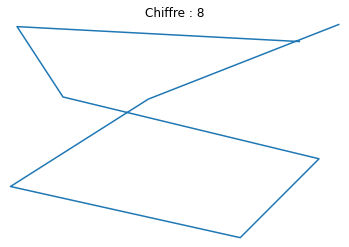

In [7]:
def dessin(p, x, y, chiffre):
    p.plot(x, y)
    p.set_title("Chiffre : " + str(chiffre))
    p.axis("off")
    p.set_xlim([-1, 101])
    p.set_ylim([-1, 101])

fig, ax = plt.subplots()
dessin(ax, x, y, chiffre)

Ensuite, nous créons une liste de `DataFrame`, un pour chaque chiffre. La fonction `query()` permet donc de sélectionner des lignes d'un `DataFrame` en fonction d'une condition (ici, `chiffre` égal 0, 1, ..., 9). Pour éviter les problèmes d'index plus tard, nous devons les réinitialiser pour chaque `DataFrame`, avec la fonction `reset_index()`, en mettant `drop` à vrai. Ceci permet d'oublier les numéros de ligne du `DataFrame` global et que ceux-ci recommencent de 0 pour chaque sous-ensemble.

In [8]:
sub = [pen.query("chiffre == " + str(i)).reset_index(drop = True) for i in range(10)]

Nous voulons maintenant représenter chaque premier exemple de chaque chiffre. Pour cela, nous recherchons la première ligne (`index = 0`) pour chaque sous-ensemble précédemment créé. Et pour simplifier le travail ensuite, nous renvoyons pour chaque chiffre, trois éléments : les $x_j$, les $y_j$ et le chiffre.

In [9]:
sub_first_xyc = [[s.loc[0, xN], s.loc[0, yN], s.loc[0, "chiffre"]] for s in sub]

Puis, nous créons une figure (en spécifiant la taille). Et pour chaque chiffre, nous ajoutons un graphique à la figure avec la fonction `add_subplot()`. Celle-ci prend trois paramètres : le nombre de lignes, le nombre de colonnes et le numéro de placement du prochain graphique. Grâce à l'utilisation de la fonction  `dessin()` et de l'objet `subxyc`, la réalisation est simple.

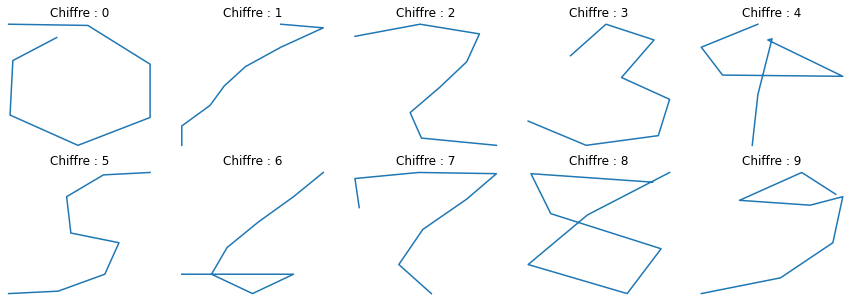

In [10]:
fig = plt.figure(figsize = (15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1) # on ajoute un sous-graphique à la position i+1
    dessin(ax, sub_first_xyc[i][0], sub_first_xyc[i][1], sub_first_xyc[i][2])

Le but de ce TP va être de réfléchir à comment répondre à la question suivante :

> Existe-t'il plusieurs façons d'écrire chaque chiffre ?

Pour cela, nous allons dérouler les étapes suivantes :

1. Calculer la moyenne de chaque coordonnée $x_j$ et $y_j$, pour chaque chiffre
1. Représenter le tracé des *chiffres moyens* (i.e. en prenant les coordonnées moyennes donc)
    - Améliorer éventuellement la fonction `dessin()` pour ajouter, si demandé, les numéros des points
1. Réaliser une ACP sur les données (en comparant avec ou sans standardisation)
1. Représenter les chiffres sur le plan factoriel
    - sur un seul graphique
    - avec un graphique par chiffre, sur la même figure
1. Réaliser une classification via HAC et $k$-means pour chaque chiffre
    - créer une fonction prenant en paramètre un nombre de classes à tester et qui réalise les opérations suivantes :
        - calcul de la partition
        - affichage de la répartition des classes (*i.e* combien d'individus dans chaque classe ?)
        - représentation des classes sur le plan factoriel (un graphique par classe éventuellement)
        - représentation des tracés moyens pour chaque classe afin de mieux comprendre les différences entre les classes
    - A l'aide de cette fonction, choisir un nombre de classes approprié
